In [3]:
# %load_ext autoreload
# %autoreload 2

In [1]:
import statistics
import torch
import torch.nn as nn
from torch.utils import data

import numpy as np
import torch.nn.functional as F
from tqdm import tqdm

In [2]:
import data_loader
import evaluation

raw_train_dataset, raw_test_dataset, tokens_vocab, y_vocab = data_loader.load_raw_data(S=100)

In [3]:
idx = 1
print(raw_train_dataset['int_sentences'][idx])
print(raw_train_dataset['str_sentences'][idx])
print(raw_train_dataset['int_labels'][idx])
print(raw_train_dataset['str_labels'][idx])

[15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 18, 25, 26, 27, 28, 29, 30, 31, 32, 7, 33, 34, 35, 7, 23, 36, 37, 38, 39, 7, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 18, 51, 52, 53, 54, 55, 43, 56, 14]
['Garth', 'was', 'prepared', 'to', 'be', 'helpful', 'in', 'what', 'he', 'referred', 'to', 'with', 'fastidious', 'distaste', 'as', 'this', 'unfortunate', 'Johnston', 'affair', ',', 'which', 'would', 'not', ',', 'he', 'said', 'more', 'than', 'once', ',', 'have', 'ever', 'come', 'about', 'if', 'Mrs.', 'Meeker', 'had', 'only', 'seen', 'fit', 'to', 'consult', 'Mr.', 'Hohlbein', 'or', 'him', 'about', 'it', '.']
[11, 12, 13, 1, 12, 14, 1, 1, 1, 15, 1, 1, 16, 17, 1, 1, 18, 11, 19, 1, 1, 1, 20, 1, 1, 21, 22, 1, 23, 1, 1, 24, 25, 25, 1, 11, 11, 1, 26, 27, 28, 1, 29, 11, 11, 1, 1, 1, 1, 1]
['person.n.01', 'be.v.01', 'prepared.a.01', 'no_sense', 'be.v.01', 'helpful.a.01', 'no_sense', 'no_sense', 'no_sense', 'mention.v.01', 'no_sense', 'no_sense', 'fastidious.a.01', 'antipathy.n.01', 'no_sense', 'no_sens

In [4]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

device

device(type='cpu')

In [5]:
import math

class WSDModel(nn.Module):
    def __init__(self, V, Y, D=300):
        super(WSDModel, self).__init__()
        self.D = D
        
        self.E_v = nn.Embedding(V, D)
        self.E_y = nn.Embedding(Y, D)
        
#         self.W_A = nn.Parameter(torch.randn(D, D, requires_grad=True, device=device))
#         self.W_O = nn.Parameter(torch.randn(D, D, requires_grad=True, device=device))
        
        self.W_A = nn.Linear(D, D, bias=False)  # nn.Parameter(torch.Tensor(D, D))
        self.W_O = nn.Linear(D, D, bias=False)  # nn.Parameter(torch.Tensor(D, D))
        
        self.softmax = torch.nn.Softmax(dim=-1)
        self.tanh = nn.Tanh()
        
    def attention(self, X, Q):
        # X: [B, N, D]
        # Q: [B, 1, D]

        # A: [B, 1, N] 
        Q = self.W_A(Q) / math.sqrt(self.D)
        A = self.softmax(Q @ X.transpose(1, 2))
        Q_c = A @ X
        Q_c = self.W_O(Q_c)
        return Q_c, A
    
    def forward(self, M_s, v_q):
        # M_s: [B, N]
        # v_q: [B]
        
        X = self.E_v(M_s)
        
        # TODO: https://pytorch.org/docs/stable/torch.html#torch.gather
        Q_idxs = M_s[range(v_q.shape[0]), v_q]
        Q = self.E_v(Q_idxs).unsqueeze(1)

        Q_c, A = self.attention(X, Q)
#         Q_c, A = self.attention_2(X, Q)
        
        H = F.relu(Q_c + Q)
        y_logits = (H @ self.E_y.weight.T).squeeze()
        return y_logits, A.squeeze()

In [6]:
wsd_train_dataset = data_loader.WSDDataset(raw_train_dataset, tokens_vocab, y_vocab)
wsd_train_dataset

Samples: 704 (no_sense: 0)
Sentences: 100 (N=59)
Vocab:
	Tokens:1688
	Senses:877

In [7]:
wsd_test_dataset = data_loader.WSDDataset(raw_test_dataset, tokens_vocab, y_vocab)
wsd_test_dataset

Samples: 563 (no_sense: 0)
Sentences: 100 (N=63)
Vocab:
	Tokens:1688
	Senses:877

In [8]:
torch.manual_seed(0)

val_size = int(len(wsd_train_dataset)/5)
train_dataset, val_dataset = torch.utils.data.random_split(wsd_train_dataset, [len(wsd_train_dataset) - val_size, val_size])

In [9]:
B = 64

training_generator = data.DataLoader(
    train_dataset, 
    batch_size=B, 
    shuffle=True,
    num_workers=1
)

val_generator = data.DataLoader(
    val_dataset, 
    batch_size=B, 
    shuffle=True,
    num_workers=1
)

In [10]:
torch.manual_seed(0)

V = tokens_vocab.size()
Y = y_vocab.size()
model = WSDModel(V, Y, D=200).to(device)

print(model.W_A.weight.t().sum())
print(model.W_O.weight.t().sum())
print(model.E_v.weight.t().sum())
print(model.E_y.weight.sum())

tensor(-3.3350, grad_fn=<SumBackward0>)
tensor(-1.2460, grad_fn=<SumBackward0>)
tensor(-1341.5393, grad_fn=<SumBackward0>)
tensor(40.1151, grad_fn=<SumBackward0>)


In [11]:
B = 64

training_generator = data.DataLoader(
    train_dataset, 
    batch_size=B, 
    shuffle=True,
    num_workers=1
)

val_generator = data.DataLoader(
    val_dataset, 
    batch_size=B, 
    shuffle=True,
    num_workers=1
)

In [12]:
ce_loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

losses = []
train_acc = []
val_acc = []

for epoch in range(5):
    with tqdm(training_generator) as prg_train:
        for M_s, v_q, y_true in prg_train:
            M_s, v_q, y_true = M_s.to(device), v_q.to(device), y_true.to(device)

            ## SHAPES:
            # M_s     --> [B, N]
            # M_q     --> [B]
            # y_true  --> [B]
            
            optimizer.zero_grad()

            y_logits, _ = model(M_s, v_q)
#             print(y_logits.shape)
            loss = ce_loss(y_logits, y_true)
            loss.backward()
            optimizer.step()

            losses.append(loss.item())
            running_mean_loss = statistics.mean(losses[-min(len(losses), 100):])
            status_str = f'[{epoch}] loss: {running_mean_loss:.3f}'
            prg_train.set_description(status_str)
        
        with torch.set_grad_enabled(False):
            cur_train_acc = evaluation.evaluate(model, training_generator)
            train_acc.append(cur_train_acc)
            
            cur_val_acc = evaluation.evaluate(model, val_generator)
            val_acc.append(cur_val_acc)

[4] loss: 9.197: 100%|██████████| 9/9 [00:00<00:00, 10.15it/s]


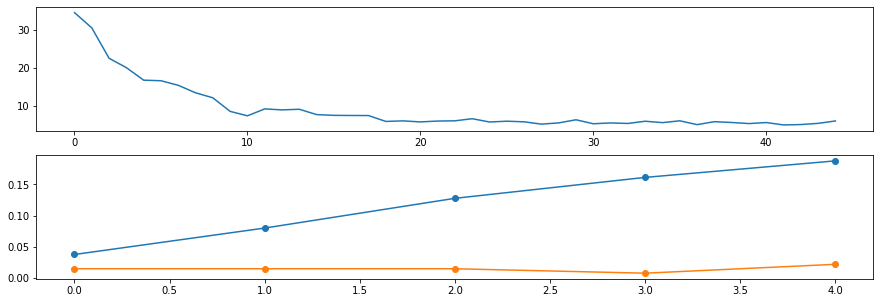

In [13]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows=2, figsize=(15, 5))

axs[0].plot(losses, '-');
axs[1].plot(train_acc, '-o');
axs[1].plot(val_acc, '-o');

In [14]:
train_acc[-1]

0.1879432624113475

In [16]:
test_loader = data.DataLoader(wsd_test_dataset)

test_acc = None
with torch.set_grad_enabled(False):
    test_acc = evaluation.evaluate(model, test_loader)
    
print(f'Test Accuracy: {test_acc:.2f}')

Test Accuracy: 0.01


In [17]:
import pandas as pd

pd.set_option('max_columns', 100)

g = data.DataLoader(
    wsd_train_dataset, 
    batch_size=32, 
    shuffle=True,
    num_workers=4
)

acc, eval_df, attention_df = evaluation.evaluate_verbose(model, g, tokens_vocab, y_vocab, iter_lim=None)

In [18]:
len(eval_df[eval_df['y_true'] == 'no_sense'])

0

In [19]:
ev_styled, att_styled = evaluation.fancy_display(eval_df, attention_df, slice(0, 5))
ev_styled

,index,query,y_true,y_pred,y_pred_prob,y_pred_loss,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58
0,0,25,state.v.01,paraphrase.v.01,1.140e-03,6.776419,Garth,was,prepared,to,be,helpful,in,what,he,referred,to,with,fastidious,distaste,as,this,unfortunate,Johnston,affair,",",which,would,not,",",he,said,more,than,once,",",have,ever,come,about,if,Mrs.,Meeker,had,only,seen,fit,to,consult,Mr.,Hohlbein,or,him,about,it,.,,,,,,,,,
1,1,31,cool.a.01,paraphrase.v.01,1.140e-03,6.776419,It,was,a,Cadillac,",",black,grayed,with,the,dust,of,the,road,",",its,windows,closed,tight,so,you,knew,that,the,people,who,climbed,out,of,it,would,be,cool,and,unwrinkled,.,,,,,,,,,,,,,,,,,,,,,,,,
2,2,1,be.v.01,paraphrase.v.01,1.140e-03,6.776419,They,were,carpeted,",",but,made,for,pumps,and,congress,gaiters,",",not,the,great,clodhoppers,he,wore,.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3,3,10,volition.n.01,paraphrase.v.01,1.140e-03,6.776419,Law,was,seen,as,an,emanation,of,the,``,sovereign,will,'',.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4,4,3,make.v.03,paraphrase.v.01,1.140e-03,6.776419,Strenuous,efforts,were,made,to,remove,pin,pricking,from,administration,statements,.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


In [20]:
att_styled

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58
0,4.68e-02,7.28e-03,1.43e-02,7.90e-03,3.06e-03,1.37e-02,1.70e-03,1.14e-02,1.26e-02,6.92e-03,7.90e-03,1.89e-02,7.60e-03,1.68e-02,4.87e-04,1.35e-02,2.02e-03,1.12e-02,1.83e-03,1.16e-03,1.25e-02,7.51e-03,7.22e-03,1.16e-03,1.26e-02,6.27e-03,2.81e-03,6.95e-03,2.56e-03,1.16e-03,1.06e-02,9.25e-03,8.07e-02,3.99e-03,2.57e-03,7.97e-03,5.08e-03,1.27e-02,5.68e-03,1.20e-01,8.89e-03,7.90e-03,8.79e-03,3.37e-03,3.32e-03,4.80e-02,3.40e-03,3.99e-03,1.88e-02,8.66e-04,4.07e-02,4.07e-02,4.07e-02,4.07e-02,4.07e-02,4.07e-02,4.07e-02,4.07e-02,4.07e-02
1,6.90e-04,1.05e-04,2.60e-04,2.73e-04,2.99e-04,1.03e-02,1.84e-03,1.18e-04,1.15e-03,2.28e-03,8.80e-04,1.15e-03,2.86e-03,2.99e-04,5.86e-04,6.68e-04,8.94e-04,1.42e-04,3.23e-04,9.56e-04,4.75e-04,9.95e-04,1.15e-03,7.90e-04,2.07e-04,2.37e-04,1.08e-03,8.80e-04,1.40e-03,8.32e-05,1.10e-02,4.18e-04,7.29e-04,2.88e-04,9.25e-01,1.21e-03,1.21e-03,1.21e-03,1.21e-03,1.21e-03,1.21e-03,1.21e-03,1.21e-03,1.21e-03,1.21e-03,1.21e-03,1.21e-03,1.21e-03,1.21e-03,1.21e-03,1.21e-03,1.21e-03,1.21e-03,1.21e-03,1.21e-03,1.21e-03,1.21e-03,1.21e-03,1.21e-03
2,3.10e-04,5.63e-05,2.81e-04,4.55e-05,9.86e-04,4.69e-04,2.95e-04,5.10e-04,6.09e-05,1.03e-04,3.04e-03,4.55e-05,2.91e-04,3.61e-04,7.43e-06,5.67e-04,5.64e-04,1.44e-04,4.61e-02,2.36e-02,2.36e-02,2.36e-02,2.36e-02,2.36e-02,2.36e-02,2.36e-02,2.36e-02,2.36e-02,2.36e-02,2.36e-02,2.36e-02,2.36e-02,2.36e-02,2.36e-02,2.36e-02,2.36e-02,2.36e-02,2.36e-02,2.36e-02,2.36e-02,2.36e-02,2.36e-02,2.36e-02,2.36e-02,2.36e-02,2.36e-02,2.36e-02,2.36e-02,2.36e-02,2.36e-02,2.36e-02,2.36e-02,2.36e-02,2.36e-02,2.36e-02,2.36e-02,2.36e-02,2.36e-02,2.36e-02
3,2.20e-03,2.70e-03,4.01e-03,6.62e-04,9.47e-04,1.13e-03,5.06e-03,1.43e-04,1.70e-03,1.85e-03,3.80e-03,4.29e-03,1.19e-02,2.09e-02,2.09e-02,2.09e-02,2.09e-02,2.09e-02,2.09e-02,2.09e-02,2.09e-02,2.09e-02,2.09e-02,2.09e-02,2.09e-02,2.09e-02,2.09e-02,2.09e-02,2.09e-02,2.09e-02,2.09e-02,2.09e-02,2.09e-02,2.09e-02,2.09e-02,2.09e-02,2.09e-02,2.09e-02,2.09e-02,2.09e-02,2.09e-02,2.09e-02,2.09e-02,2.09e-02,2.09e-02,2.09e-02,2.09e-02,2.09e-02,2.09e-02,2.09e-02,2.09e-02,2.09e-02,2.09e-02,2.09e-02,2.09e-02,2.09e-02,2.09e-02,2.09e-02,2.09e-02
4,3.23e-04,6.79e-05,1.32e-04,2.38e-06,3.60e-03,2.07e-04,2.70e-06,1.06e-05,1.47e-06,7.05e-06,6.22e-05,1.50e-01,1.80e-02,1.80e-02,1.80e-02,1.80e-02,1.80e-02,1.80e-02,1.80e-02,1.80e-02,1.80e-02,1.80e-02,1.80e-02,1.80e-02,1.80e-02,1.80e-02,1.80e-02,1.80e-02,1.80e-02,1.80e-02,1.80e-02,1.80e-02,1.80e-02,1.80e-02,1.80e-02,1.80e-02,1.80e-02,1.80e-02,1.80e-02,1.80e-02,1.80e-02,1.80e-02,1.80e-02,1.80e-02,1.80e-02,1.80e-02,1.80e-02,1.80e-02,1.80e-02,1.80e-02,1.80e-02,1.80e-02,1.80e-02,1.80e-02,1.80e-02,1.80e-02,1.80e-02,1.80e-02,1.80e-02
